<div class="alert-warning">
 <font size="+2"> <b> RNA-seq differential gene expression </b> </font>
</div>



This tutorial will cover the steps for performing Differential Gene Expression on the RNA-seq data obtained from Galaxy. At the end of this tutorial you will be able to use `R` to

- Perform preliminary analyses of the RNA-seq results
- Find differentially expressed genes between two conditions using `edgeR`


The present tutorial, like the rest of the course material, is available at our [open-source github repository](https://github.com/hds-sandbox/NGS_summer_course_Aarhus). 

A few introductory points to run this notebook:

* To use this notebook, use the `NGS (R)` kernel that contains the packages. Choose it by selecting `Kernel -> Change Kernel` in the menu on top of the window.


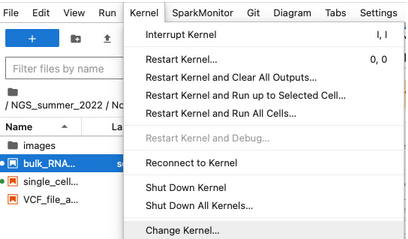

*  In this notebook we will use just R commands. 
*  You can run the code in each cell by clicking on the run cell sign, or by pressing <kbd> Shift </kbd> +<kbd> Enter </kbd>.  When the code is done running, a small green check sign will appear on the left side
*   You need to run the cells in sequential order, please do not run a cell until the one above finished running and do not skip any cells
*   Each cell contains a short description of the code and the output you should get. Please try not to focus on understanding the code for each command in too much detail, but rather try to focus on the output 
*   You can create new code cells by pressing <kbd> + </kbd> in the Menu bar above. 


    
   



# Import data from Galaxy to Ucloud

Upload the 12 tabular files with Reads per Gene counts generated by STAR Mapping on the Galaxy Server.

Download the two lists of files to your computer, unarchive them and upload them to UCloud in the folder "Galaxy_Data" which you created yesterday.

## Load the necessary R libraries

In [ ]:
library(VennDiagram)
library(dplyr)
library(tibble)
library(formattable)
library(mixOmics)
library(pheatmap)
library(edgeR)

Check if the data folder is there

In [5]:
print( system('sh ../Scripts/dataDownloadScript.sh', intern = TRUE) )

[1] "========================================================"
[2] "Datasets folder already exists, no need to download it"  
[3] "========================================================"


# edgeR - Data filtering and Normalization 

We will use the edgeR package to test for differentially expressed genes between our Control and Treatment Samples. You can read more about the edgeR package and its functionalities [here](https://www.bioconductor.org/packages/release/bioc/vignettes/edgeR/inst/doc/edgeRUsersGuide.pdf). This exercise largely follows their user manual.


## File processing

First, we will merge the 12 files with Reads per Gene information uploaded from Galaxy into a single file.
<br>
The data frame has genes as rows and samples as columns and stores the gene expression counts(value representing the total number of sequence reads that originated from a particular gene in a sample) for each of the 12 samples.
This data frame should have 12 columns and 366 rows.

In [ ]:
samples <- list.files("Galaxy_Data/", pattern=".tabular")
Read_counts <- do.call(cbind, lapply(samples, function(x) read.delim(file= paste0("Galaxy_Data/", x), header = F)))
rownames(Read_counts) <- Read_counts[,1]
Read_counts <- Read_counts[c(5:nrow(Read_counts)), c(seq(2, 46, by=4))]
colnames(Read_counts) <- c("S10_1_1", "S10_1_2", "S10_1_3", "S10_2_1", "S10_2_2", "S10_2_3", 
                       "TI_1_1", "TI_1_2", "TI_1_3", "TI_2_1", "TI_2_2", "TI_2_3")
head(Read_counts, n=10)
dim(Read_counts) # dimensions of the data frame

Import the Metadata table. This file, as its name suggests, contains information about each of the 12 RNA-seq samples, such as the treatment (Condition), genotype and replicate.

Note that the order of the rows in the Metadata table should be the same as the columns in the Read_counts file generated above. 

In [ ]:
metadata <- read.csv("../Data/Clover_Data/metadata.csv", sep =";", row.names=1, stringsAsFactors=TRUE)
metadata

In order to aid the following steps, we will create a Group for each sample (a new column in the metadata) based on the Genotype&Condition of each sample and assign the three replicates to this group.

In [ ]:
Group <- factor(paste(metadata$Genotype, metadata$Condition, sep="_"))
metadata <- cbind(metadata,Group=Group)
metadata

## Create the DGEList object
We will merge the read counts and the metadata into a list-based data object named DGEList, which can be manipulated as any list object in R.

The main components of the DGEList object are the matrix "counts" containing our read per gene counts and a data.frame "samples" containing the metadata. 

Note that all the genes with zero counts across all samples were eliminated.

In [ ]:
DGEList <- DGEList(Read_counts, remove.zeros = TRUE)
DGEList$samples$Condition <- relevel(metadata$Condition, ref = "Control")
DGEList$samples$Genotype <- metadata$Genotype
DGEList$samples$group <- metadata$Group
DGEList

## Preliminary data analysis
First, we will calculate the "pseudoCounts" as log2 of the reads per gene counts. 
<br>
This is not part of the actual differential gene expression analysis but is helpful for data exploration and quality assessment. We will look at a histogram of one of the samples and a boxplot representation of the log2 counts for all the 12 samples.
<br>
Note that there are many genes with a low number of mapped reads and that there are differences between the average read counts for each library. 

In [ ]:
pseudoCounts <- log2(DGEList$counts + 1)
head(pseudoCounts)
hist(pseudoCounts[ ,"S10_1_1"], main = "", xlab = "Read counts")
boxplot(pseudoCounts, col = "gray", las = 3, cex.names = 1)

We can also create a PCA plot of the samples in order to assess the differences between the Genotypes and Conditions, but also between the replicates. In this plot the samples that are similar cluster together, while samples that are different are further apart.
<br>
In this type of plot, we would expect samples from the same group (the three replicates for each sample) to exhibit a similar gene expression profile thus clustering together while being separated from the other samples.

In [ ]:
resPCA <- pca(t(pseudoCounts), ncomp = 6)
plotIndiv(resPCA, group = metadata$Genotype, pch=metadata$Condition,
                  legend = T, legend.title = 'Genotype', legend.title.pch = 'Condition',
                  title = 'PCA plot raw counts', style = 'ggplot2', size.xlabel = 10, size.ylabel = 10)

## Filtering the lowly expressed genes
As seen previously, many genes have a low number of read counts in our samples. The genes with very low counts across all libraries provide little evidence for differential expression, thus we should eliminate these genes before the analysis. 
<br>
One of the filtering methods we can use is the "filterByExpr" function provided by the edgeR package. By default, this function keeps only the genes that have at least 10 reads per group, but other cutoffs can also be applied.

In [ ]:
keep <- filterByExpr(DGEList, group=metadata$Group) #create the filter
DGEList <- DGEList[keep, , keep.lib.sizes=FALSE] #apply the filter to on the DGEList object
table(keep) #Check the number of genes that passed the filter

## Normalization
As we are working with multiple samples we need to normalize the read counts per gene in order to account for compositional and technical differences between the 12 RNA-seq libraries. For this, we will calculate normalization factors using the trimmed mean of M-values (TMM) method. You can read more about different normalization methods in the user manual.  
<br>
Note that running "calcNormFactors" does not change the actual reads per gene counts, it just fills the "norm.factors" column in DGEList$samples. 

These factors will be used to scale the read counts for each library.
From the user guide: "A normalization factor below one indicates that a small number of high count genes
are monopolizing the sequencing, causing the counts for other genes to be lower than would
be usual given the library size."

In [ ]:
DGEList <- calcNormFactors(DGEList, method="TMM")
DGEList$samples

## Normalized counts - Exploratory Data analysis
For data analysis purposes normalized log2 counts can be extracted from the DGEList object using the function CPM (counts per million).

We will generate the same plots as for the raw counts in order to compare the data before and after normalization. 

Do the plots for normalized counts look different compared with the plots computed before data filtering and normalization? 

In [ ]:
pseudoNormCounts <- cpm(DGEList, log = TRUE, prior.count = 1)
head(pseudoNormCounts)
hist(pseudoNormCounts[ ,"S10_1_1"], main = "", xlab = "counts")
boxplot(pseudoNormCounts, col = "gray", las = 3, cex.names = 1)

resPCA <- pca(t(pseudoNormCounts), ncomp = 6)
plotIndiv(resPCA, group = metadata$Genotype, pch=metadata$Condition,
                  legend = T, legend.title = 'Genotype', legend.title.pch = 'Condition',
                  title = 'PCA plot normalized counts', style = 'ggplot2', size.xlabel = 10, size.ylabel = 10)

# edgeR - Testing for Differentially expressed genes (DEGs) using the GLM method (Generalized linear model) with treatment and genotype effects


After we concluded the exploratory data analysis and the filtering and normalization steps we can now start testing for differentially expressed genes between our samples. 


For this, we first need to define a "design matrix" which describes our experimental design. We construct a matrix containing samples as rows and our previously defined groups (S10_Control, S10_Treatment, Tienshan_Control, Tienshan_Treatment) as columns. The samples belonging to each group are assigned a "1" in this matrix.   

In [ ]:
design.matrix <- model.matrix(~0+Group)
rownames(design.matrix) <- colnames(DGEList)
colnames(design.matrix) <- levels(metadata$Group)
design.matrix

For easier pairwise comparisons between the groups we can create some "contrasts" using the "makeContrasts" function. This will tell the program which samples we will like to consider as our "Control" and which as our "Treatment" groups. The Control groups will be assigned a "-1" and the Treatment groups a "1". When using multiple Control and Treatment samples in the same contrast we need to devide by the number of samples used as for example in the contrast S10_Tienshan, where we use both S10 and Ti samples.

For example, the contrast "S10 = S10_Treatment - S10_Control" will test for differentially expressed genes between the S10 treatment samples vs the S10 Control samples. 

In [ ]:
contrasts <- makeContrasts(
                S10 = S10_Treatment-S10_Control,
                Tienshan = Tienshan_Treatment-Tienshan_Control,
                S10_Tienshan= (S10_Treatment+Tienshan_Treatment)/2 - (S10_Control+Tienshan_Control)/2,
                levels=design.matrix)
contrasts

*   *Any ideas for other contrasts that migth be interesting to explore?*







The following cell will run two mandatory steps in order to fit a model in edgeR. First, the dispersion needs to be estimated, this is a measure of the degree of inter-library variation for each gene. Afterwards, a QL ( quasi-likelihood) model representing the sample design is fitted using the "glmQLFit" function. You can read more about these steps in the edgeR user guide.

In [ ]:
DGEList <- estimateDisp(DGEList, design.matrix)
fit <- glmQLFit(DGEList, design.matrix)
#plotBCV(DGEList)

### Find DEGs

Find DEGs for White clover S10 plants in Treatment condition compared with the Control condition
We will test for differentially expressed genes using the quasi-likelihood F-tests method. This is easily done just by running the "glmQFTest" function on the fit model and selecting one of the contrasts we created above (in this case the "S10" contrast).

Next, we will use the topTags function to extract the information about all the genes.

In [ ]:
glmqlf_S10 <- glmQLFTest(fit, contrast=contrasts[,"S10"])
DEG_S10 <- topTags(glmqlf_S10, n = nrow(DGEList$counts))
DEG_S10

We have now created a table with certain parameters calculated for each of the genes analysed.

**logFC** represents the base 2 logarithm of the fold change and it shows us how much the expression of the gene has changed between the two conditions. A logFC of 1 means a doubling in the read per gene count between the control and treatment samples.
The genes with a logFC higher than 0 are upregulated while the genes with a logFC lower than 0 are downregulated between the control and treatment samples. 
<br>
**logCPM** represents the average log2-counts-per-million, the abundance of the gene.

**F** - F-statistic.

**PValue** is the raw p-value.

**FDR** (The false discovery rate) represents the adjusted p-value and is calculated using Benjamini and Hochberg's algorithm. It controls the rate of false positive values under multiple testing. Usually, a threshold of under 5% is set for the FDR.  

The important information for us in this table is stored in the "logFC" and the "FDR" columns. The top DE genes have small FDR values and large fold changes

Many of the genes in the samples are uninteresting for us, as they have a high FDR and/or low logFC values so we cannot consider them as differentially expressed.

We will apply a filtering step in order to keep only the statistically significant genes. We will filter out the genes with an FDR higher than 0.05 and an absolute logFC lower than 1.

In [ ]:
DEG_S10_filtered <- DEG_S10$table[DEG_S10$table$FDR < 0.05 & abs(DEG_S10$table$logFC) > 1,] #Filtering
DEG_S10_filtered <- rownames_to_column(DEG_S10_filtered) %>% rename(gene_ID = rowname) #Adding the gene_ID column
head(DEG_S10_filtered)
nrow(DEG_S10_filtered) # finding the number of genes that passed the filter 

We can also visualize the selected genes by plotting a Smear plot or a Volcano plot. The Genes that passed the filter are coloured in red, and the top 10 genes with the lowest FDR value are labelled with their gene ID.

We can see that the majority of the genes analysed are either not statistically significant or have a very small logFC.

In [ ]:
plotSmear(glmqlf_S10,
          de.tags = rownames(DEG_S10$table)[which(DEG_S10$table$FDR < 0.05 & abs(DEG_S10$table$logFC) > 1)])
text(x=DEG_S10_filtered$logCPM[1:10],
     y=DEG_S10_filtered$logFC[1:10],
     labels=DEG_S10_filtered$gene_ID[1:10], cex=0.7, pos=1)
abline(h = c(-1, 1), col = "blue")

We can also create a heatmap with the log2 read counts of the selected differentially expressed genes so that we can visualise the differences in normalized counts between the Control and the Treatment samples.

The genes are ordered by the FDR value. 

In [ ]:
annot_col <- data.frame(row.names = colnames(pseudoNormCounts)[1:6], Condition = c(rep("Control", 3),rep( "Treatment", 3)))                   
pheatmap(as.matrix(pseudoNormCounts[DEG_S10_filtered$gene_ID,c(1:6)]), cluster_rows = F, cluster_col = F, annotation_col = annot_col)

## Find DEGs for White clover Tienshan plants Treatment vs Control
We can do this using the same functions as above and changing the contrast.

This time we will directly filter the differentially expressed genes using the same parameters as for the S10 samples.

In [ ]:
glmqlf_Ti <- glmQLFTest(fit, contrast=contrasts[,"Tienshan"])
DEG_Ti <- topTags(glmqlf_Ti, n = nrow(DGEList$counts))
DEG_Ti_filtered <- DEG_Ti$table[DEG_Ti$table$FDR < 0.05 & abs(DEG_Ti$table$logFC) > 1,]
DEG_Ti_filtered <- rownames_to_column(DEG_Ti_filtered) %>% rename(gene_ID = rowname)
print(head(DEG_Ti_filtered))
nrow(DEG_Ti_filtered)

We can now plot a Venn diagram with the DEGs for the two genotypes in order to observe the number of common and specific differentially expressed genes between the two genotypes as response to the cold exposure. You can see that a high percentage of the identified genes are common for the two genotypes, while each genotype has also specific genes.

In [ ]:
vd <- venn.diagram(
  x = list(DEG_S10_filtered$gene_ID, DEG_Ti_filtered$gene_ID),
  category.names = c("S10" , "Tienshan"),
  lwd = 4,
  fill = c("cornflowerblue", "yellowgreen"),
  filename = NULL,
  cat.cex = 1,
  cat.fontface = "bold",
  output=TRUE
)
grid.draw(vd)

## Find DEGs for S10+Tienshan, Treatment vs Control, without accounting for genotype effects
Until now we tested for DEGs specific for each of the two genotypes under cold treatment. We can also run a test where we ignore the genotype and just test for the differences in the cold response.
<br>
Consider the counts for both genotypes as a single dataset using the previously created contrast "S10_Tienshan". 
<br>
* Do the results look different compared with the previous tests?

In [ ]:
glmqlf_S10_Ti <- glmQLFTest(fit, contrast=contrasts[,"S10_Tienshan"])
DEG_S10_Ti <- topTags(glmqlf_S10_Ti, n = nrow(DGEList$counts))
DEG_S10_Ti_filtered <- DEG_S10_Ti$table[DEG_S10_Ti$table$FDR < 0.05 & abs(DEG_S10_Ti$table$logFC) > 1,]
DEG_S10_Ti_filtered <- rownames_to_column(DEG_S10_Ti_filtered)  %>% rename(gene_ID = rowname)
print(head(DEG_S10_Ti_filtered))
nrow(DEG_S10_Ti_filtered)

Plot the results from the 3 tests in a Venn diagram to visualize the number of common and unique genes

In [ ]:
vd <- venn.diagram(
  x = list(DEG_S10_filtered$gene_ID, DEG_Ti_filtered$gene_ID,
           DEG_S10_Ti_filtered$gene_ID),
  category.names = c("S10" , "Tienshan", "S10_Tienshan"),
  lwd = 3,
  fill = c("cornflowerblue", "yellowgreen", "thistle3"),
  filename = NULL,
  cat.cex = 1,
  cat.fontface = "bold",
  output=TRUE
)
grid.draw(vd)

### Select the genes which appear only in the analysis using both genotypes for further examination.
We can use the "anti_join" function from the dplyr package to keep only the unique genes that appear only when using both genotypes.

In [ ]:
S10_Ti_unique <- anti_join(DEG_S10_Ti_filtered, DEG_S10_filtered, by="gene_ID") %>%
                       anti_join(DEG_Ti_filtered, by="gene_ID")
S10_Ti_unique

### Linking the genes selected as differentially expressed back to the raw read counts
How do the counts look for these genes, does it make sense that they are differentially expressed only when using the two genotypes?

In [ ]:
Read_counts <- rownames_to_column(Read_counts) %>% rename(gene_ID = rowname)
S10_Ti_unique_counts <- inner_join(S10_Ti_unique[,c(1,2,6)], Read_counts, by="gene_ID")
S10_Ti_unique_counts

### Adding functional annotation to DEGs
Until now we looked only at gene IDs, but we can also add functional annotations to the DEGs. The functional annotations were generated using protein sequences and the `EggNOG` software.

Identifying the molecular function of the differentially expressed genes can help us do a literature survey in order to check if any of the genes discovered have been previously identified as being involved in the cold response.

In [ ]:
Functional_annotations <- read.delim("../Data/Clover_Data/Functional_Annotations.txt")
S10_Ti_unique_FA <- inner_join(S10_Ti_unique[,c(1,2,6)], Functional_annotations, by="gene_ID")
S10_Ti_unique_FA

<div class="alert-success"> <font size="+2"> <b> Tasks and Questions </b> </font> </div>


*   Based on the results obtained in the analysis so far, would you change the cut-off for the FDR and logFC to be more strict or more permissive? Look back at the raw counts for different FDR and logFC values and set the thresholds as you find appropriate.

You can also plot histograms with the FDR and logFC values. 





In [ ]:
 hist(DEG_S10$table$FDR , main = "", xlab = "FDR",  breaks= 200, xlim = range(c(0, 0.1)))

In [ ]:
 hist(DEG_S10$table$logFC , main = "", xlab = "logFC",  breaks= 50, xlim = range(c(-6, 6)))

* Separate the upregulated and downregulated genes for each genotype and append functional annotations to them. 
* Identify the genes that are commonly upregulated in S10 and Tienshan samples and the uniquely upregulated genes for each genotype.
* Why do you think some of the proteins appear in duplicates? <br>

To answer these questions, it may be convenient to save summary tables from R and open them in excel. See the code below for examples of how to do this. Files can be downloaded by right-clicking on the file name.

If you are familiar with R functions, you are welcome to use those for counting.

Fill your results into the table shown in the exercise manual.


In [ ]:
dir.create("DEG_Output_tables", showWarnings = FALSE)

In [ ]:
#Create the table with the DEGs, Raw counts(just for the Ti samples in this case, change to columns (2:7) for the S10 samples) and Functional annotations
DEG_Ti_counts_FA <- inner_join(DEG_Ti_filtered[,c(1, 2, 6)], Read_counts[, c(1, 8:13)], by="gene_ID") %>%
                 inner_join(Functional_annotations, by="gene_ID")
#Write the table to file
write.table(DEG_Ti_counts_FA, file = "DEG_Output_tables/Ti_Treatment_Control_DGE.txt", quote = FALSE, row.names = FALSE, sep = "\t")
#Display the first 10 rows of the table
head(DEG_Ti_counts_FA, n=10)

Example for filtering and counting the Up/Down genes. You can easily filter using the "filter()" function just by specifying the dataframe and a logical argument.

In [ ]:
DEG_Ti_up <- filter(DEG_Ti_counts_FA, logFC > 0)
nrow(DEG_Ti_up)
DEG_Ti_down <- filter(DEG_Ti_counts_FA, logFC < 0)
nrow(DEG_Ti_down)

You can use the "inner_join" and the "anti_join" functions from the dplyr package to select the common and unique genes for each genotype:

`example_file_joined <- inner_join(file1, file2, by="gene_ID")`

# Wrapping up  🎉 🎉 🎉

In this notebook, you have worked with RNA-seq results for two white clover genotypes exposed to one night of cold treatment, aiming to identify genes that change their expression in response to the cold treatment. You have learned to perform exploratory data analysis of raw and normalized RNA-seq read counts. You have also performed differential gene expression using `edgeR`. 